# MYSQL 연동

In [1]:
import mysql.connector
from mysql.connector import connect,Error
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings(action='ignore')
#warnings.filterwarnings(action='default')

In [3]:
def create_mysql_connection(host, user, password, database):
    try:
        connection = connect(
            host = host,
            user = user,
            password = password,
            database = database
        )
        if connection.is_connected():
            print(f'Connected to MySQL server : {host}')
        return connection
    except Error as e:
        print(f'Error: {e}')
        return None

def close_connection(connection):
    if connection:
        connection.close()
        print('Connection to MYSQL closed.')

In [4]:
connection = create_mysql_connection('localhost', 'root', '579579', 'yammer')

Connected to MySQL server : localhost


In [11]:
#close_connection(connection)

# 1. A/B Test Result Check

### 1-1. Average Messages Sent

In [ ]:
avg_messages_num_q="""
SELECT experiment_group,
       COUNT(user_id) as users,
       AVG(cnt_send_message) as average,
       SUM(cnt_send_message) as total
FROM (
      SELECT ex.user_id, 
             ex.experiment_group,
             COUNT(e.event_name) as cnt_send_message
      FROM experiments ex
            INNER JOIN users u ON ex.user_id = u.user_id
            LEFT JOIN events e
                        ON ex.user_id = e.user_id
                        AND e.occurred_at BETWEEN ex.occurred_at AND '2014-06-30 23:59:59'
                        AND e.event_name = 'send_message' 
      WHERE experiment = 'publisher_update'
      GROUP BY ex.user_id, ex.experiment, ex.experiment_group
      ) send_m_by_user
GROUP BY experiment_group
"""
avg_messages_num = pd.read_sql(avg_messages_num_q, connection)
avg_messages_num

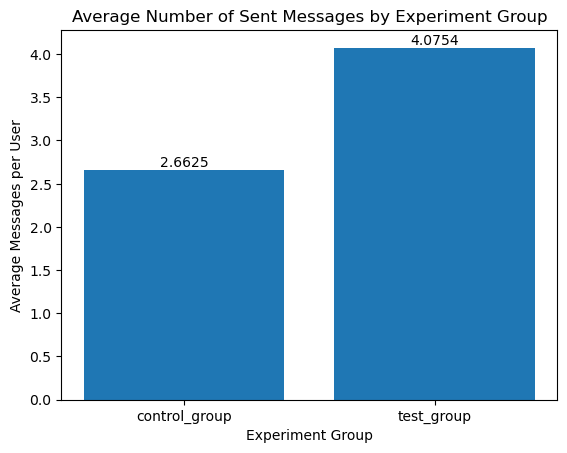

In [13]:
x = avg_messages_num["experiment_group"]
y = avg_messages_num["average"]

plt.figure()
bars = plt.bar(x, y)

plt.xlabel("Experiment Group")
plt.ylabel("Average Messages per User")
plt.title("Average Number of Sent Messages by Experiment Group")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        height, 
        ha="center",
        va="bottom"
    )

plt.show()

### 1-2. T-test

In [14]:
additional_test_q="""
SELECT c.experiment_group,
      c.users,
      c.total_treated_users,
      c.total AS total_message,
      c.average AS average_message,
      ROUND((c.average - c.control_average) / SQRT((c.variance/c.users) + (c.control_variance/c.control_users)),4) AS t_stat,
      (1 - COALESCE(nd.value,1))*2 AS p_value
  FROM (
        SELECT *,
              MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.users ELSE NULL END) OVER () AS control_users,
              MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.average ELSE NULL END) OVER () AS control_average,
              MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.total ELSE NULL END) OVER () AS control_total,
              MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.variance ELSE NULL END) OVER () AS control_variance,
              MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.stdev ELSE NULL END) OVER () AS control_stdev,
              SUM(b.users) OVER () AS total_treated_users
          FROM (
                SELECT sm.experiment_group,
                       COUNT(sm.user_id) AS users,
                       AVG(sm.ct_sm) AS average,
                       SUM(sm.ct_sm) AS total,
                       STDDEV(sm.ct_sm) AS stdev,
                       VARIANCE(sm.ct_sm) AS variance
                  FROM (
                        SELECT ex.user_id,
                               ex.experiment_group,
                               ex.occurred_at,
                               COUNT(e.event_name) as ct_sm
                        FROM experiments ex
                              INNER JOIN users u ON ex.user_id = u.user_id
                              LEFT JOIN events e
                                          ON ex.user_id = e.user_id
                                          AND e.occurred_at BETWEEN ex.occurred_at AND '2014-06-30 23:59:59'
                                          AND e.event_name = 'send_message' 
                        WHERE experiment = 'publisher_update'
                        GROUP BY ex.user_id, ex.experiment_group, ex.occurred_at
                       ) sm
                GROUP BY sm.experiment_group
              ) b
      ) c
  LEFT JOIN normal_distribution nd
            ON nd.score = ABS(ROUND((c.average - c.control_average)/SQRT((c.variance/c.users) + (c.control_variance/c.control_users)),3))
            """
additional_test = pd.read_sql(additional_test_q, connection)
additional_test

,experiment_group,users,total_treated_users,total_message,average_message,t_stat,p_value
0,control_group,1745,2594.0,4646.0,2.6625,0.0000,1.0
1,test_group,849,2594.0,3460.0,4.0754,7.6674,0.0


# 2. Metric Changes

### 2-1. Average Number of Logins

In [15]:
avg_login_num_q="""
SELECT experiment_group,
       COUNT(user_id) as users,
       AVG(cnt_login) as login_average,
       SUM(cnt_login) as login_total
FROM (
      SELECT ex.user_id, 
             ex.experiment_group,
             COUNT(CASE WHEN e.event_name = 'login' THEN e.user_id ELSE NULL END) AS cnt_login
      FROM experiments ex
            INNER JOIN users u ON ex.user_id = u.user_id
            LEFT JOIN events e
                        ON ex.user_id = e.user_id
                        AND e.occurred_at BETWEEN ex.occurred_at AND '2014-06-30 23:59:59'
      WHERE experiment = 'publisher_update'
      GROUP BY ex.user_id, ex.experiment_group
      ) send_m_by_user
GROUP BY experiment_group
"""
avg_login_num = pd.read_sql(avg_login_num_q, connection)
avg_login_num

,experiment_group,users,login_average,login_total
0,control_group,1745,3.3106,5777.0
1,test_group,849,4.1001,3481.0


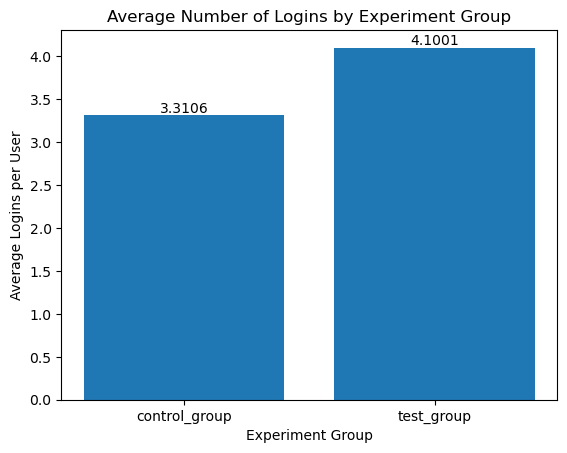

In [16]:
x = avg_login_num["experiment_group"]
y = avg_login_num["login_average"]

plt.figure()
bars = plt.bar(x, y)

plt.xlabel("Experiment Group")
plt.ylabel("Average Logins per User")
plt.title("Average Number of Logins by Experiment Group")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        height, 
        ha="center",
        va="bottom"
    )

plt.show()

### 2-2. Average Dates of Logins

In [19]:
avg_login_date_q = """
SELECT experiment_group,
       COUNT(user_id) AS users,
       AVG(login_count) AS loginday_average,
       SUM(login_count) AS loginday_total
FROM (
    SELECT ex.user_id,
           ex.experiment_group,
           COUNT(DISTINCT DATE(e.occurred_at)) AS login_count
    FROM experiments ex
    INNER JOIN users u
        ON ex.user_id = u.user_id
    LEFT JOIN events e
        ON ex.user_id = e.user_id
       AND e.occurred_at BETWEEN ex.occurred_at AND '2014-06-30 23:59:59'
       AND e.event_type = 'engagement'
    WHERE ex.experiment = 'publisher_update'
    GROUP BY ex.user_id, ex.experiment_group
) login_by_user
GROUP BY experiment_group;

"""
avg_login_date = pd.read_sql(avg_login_date_q, connection)
avg_login_date

,experiment_group,users,loginday_average,loginday_total
0,control_group,1745,3.0309,5289.0
1,test_group,849,3.6031,3059.0


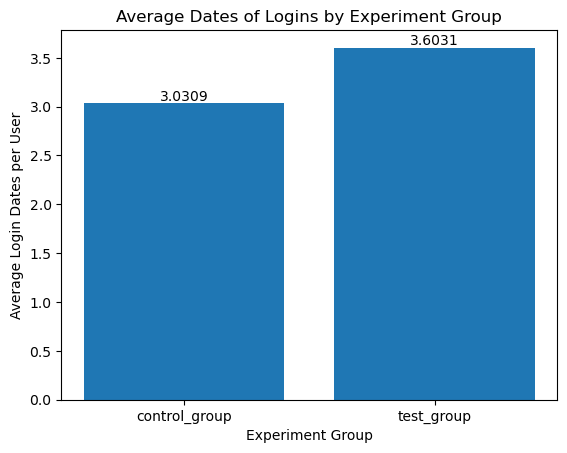

In [20]:
x = avg_login_date["experiment_group"]
y = avg_login_date["loginday_average"]

plt.figure()
bars = plt.bar(x, y)

plt.xlabel("Experiment Group")
plt.ylabel("Average Login Dates per User")
plt.title("Average Dates of Logins by Experiment Group")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        height, 
        ha="center",
        va="bottom"
    )

plt.show()

# 3. Sperate Users into New Users and Existing Users

### 3-1. Number of Users by Subscription Month (Each Experimental Group)

In [25]:
users_sub_q = """
SELECT DATE_FORMAT(u.activated_at, '%Y-%m') AS month,
       COUNT(CASE WHEN e.experiment_group = 'control_group' THEN u.user_id END) AS control_users,
       COUNT(CASE WHEN e.experiment_group = 'test_group' THEN u.user_id END) AS test_users
FROM experiments e
JOIN users u
  ON u.user_id = e.user_id
GROUP BY month
ORDER BY month;
"""
users_sub = pd.read_sql(users_sub_q, connection)
users_sub

,month,control_users,test_users
0,2013-01,24,13
1,2013-02,27,20
2,2013-03,15,32
3,2013-04,28,27
4,2013-05,15,30
5,2013-06,22,19
6,2013-07,32,32
7,2013-08,41,38
8,2013-09,37,45
9,2013-10,46,45


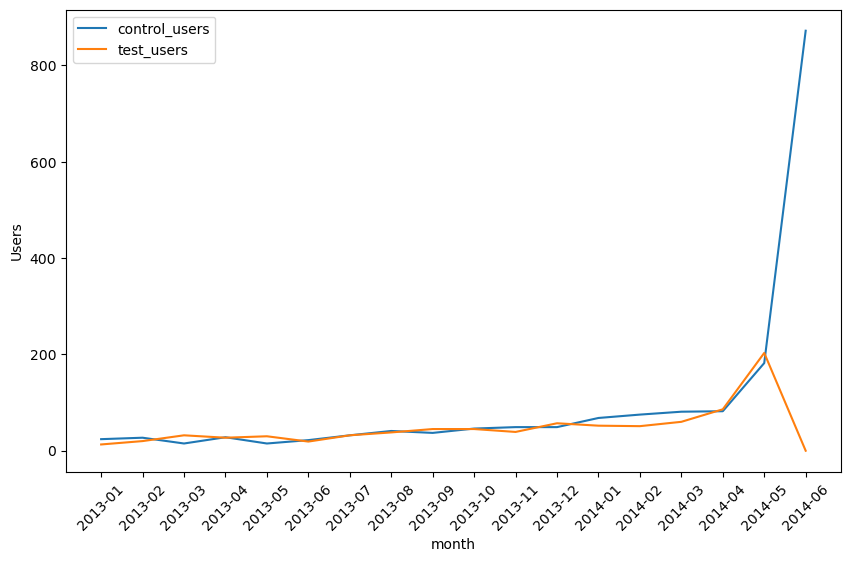

In [32]:
plt.figure(figsize=(10,6))

sns.lineplot(data=users_sub, x='month', y='control_users', label='control_users')
sns.lineplot(data=users_sub, x='month', y='test_users', label='test_users')

plt.ylabel("Users")
plt.xticks(rotation=45)
plt.legend()

plt.show()

### 3-2. Average Messages Sent by Existing Users

In [34]:
avg_messages_num_ex_q = """
SELECT experiment_group,
       COUNT(user_id) as users,
       AVG(cnt_send_message) as average,
       SUM(cnt_send_message) as total
FROM (
      SELECT ex.user_id, 
             ex.experiment_group,
             COUNT(e.event_name) as cnt_send_message
      FROM experiments ex
            INNER JOIN users u
                        ON ex.user_id = u.user_id
                        AND u.activated_at < '2014-06-01 00:00:00' -- 조건 추가
            LEFT JOIN events e
                        ON ex.user_id = e.user_id
                        AND e.occurred_at BETWEEN ex.occurred_at AND '2014-06-30 23:59:59'
                        AND e.event_name = 'send_message' 
      WHERE experiment = 'publisher_update'
      GROUP BY ex.user_id, ex.experiment, ex.experiment_group
      ) send_m_by_user
GROUP BY experiment_group
"""
avg_messages_num_ex = pd.read_sql(avg_messages_num_ex_q, connection)
avg_messages_num_ex

,experiment_group,users,average,total
0,control_group,873,2.9164,2546.0
1,test_group,849,4.0754,3460.0


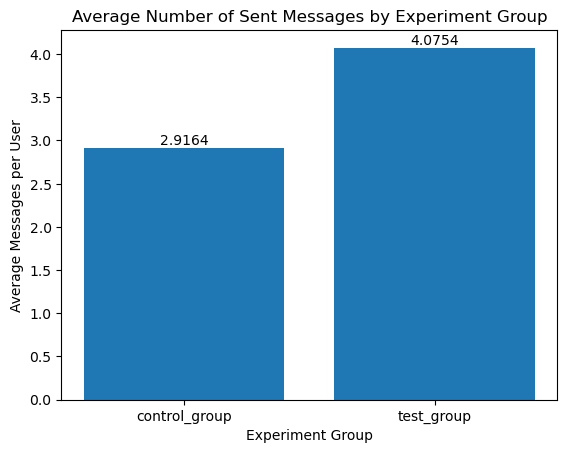

In [35]:
x = avg_messages_num_ex["experiment_group"]
y = avg_messages_num_ex["average"]

plt.figure()
bars = plt.bar(x, y)

plt.xlabel("Experiment Group")
plt.ylabel("Average Messages per User")
plt.title("Average Number of Sent Messages by Experiment Group")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        height, 
        ha="center",
        va="bottom"
    )

plt.show()

### 3-3. T-test by Existing Users

In [36]:
additional_test_ex_q="""
SELECT c.experiment_group,
       c.users,
       c.total_treated_users,
       c.total AS total_message,
       c.average AS average_message,
       ROUND(
         (c.average - c.control_average)
         / SQRT((c.variance / c.users) + (c.control_variance / c.control_users))
       , 4) AS t_stat,
       (1 - COALESCE(nd.value, 1)) * 2 AS p_value
FROM (
    SELECT *,
           MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.users END) OVER () AS control_users,
           MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.average END) OVER () AS control_average,
           MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.variance END) OVER () AS control_variance,
           SUM(b.users) OVER () AS total_treated_users
    FROM (
        SELECT sm.experiment_group,
               COUNT(sm.user_id) AS users,
               AVG(sm.ct_sm) AS average,
               SUM(sm.ct_sm) AS total,
               VARIANCE(sm.ct_sm) AS variance,
               STDDEV(sm.ct_sm) AS stdev
        FROM (
            SELECT ex.user_id,
                   ex.experiment_group,
                   COUNT(e.event_name) AS ct_sm
            FROM experiments ex
            INNER JOIN users u
              ON ex.user_id = u.user_id
             AND u.activated_at < '2014-06-01 00:00:00'   -- ✅ 코드2의 "추려진 사용자"
            LEFT JOIN events e
              ON ex.user_id = e.user_id
             AND e.occurred_at BETWEEN ex.occurred_at AND '2014-06-30 23:59:59'
             AND e.event_name = 'send_message'
            WHERE ex.experiment = 'publisher_update'
            GROUP BY ex.user_id, ex.experiment_group
        ) sm
        GROUP BY sm.experiment_group
    ) b
) c
LEFT JOIN normal_distribution nd
  ON nd.score = ABS(
       ROUND(
         (c.average - c.control_average)
         / SQRT((c.variance / c.users) + (c.control_variance / c.control_users))
       , 3)
     );

            """
additional_test_ex = pd.read_sql(additional_test_ex_q, connection)
additional_test_ex

,experiment_group,users,total_treated_users,total_message,average_message,t_stat,p_value
0,control_group,873,1722.0,2546.0,2.9164,0.0000,1.0
1,test_group,849,1722.0,3460.0,4.0754,5.5298,0.0
